# Generative Adversarial Networks

## Вступление
Одно из самых известных семейств архитектур, применяемых для генеративных задач в разных доменах, — это, конечно же, generative adversarial networks (GAN). GAN обычно состоит из двух сетей: генератора и дискриминатора. Дискриминатор пытается отличить сгенерированные объекты от реальных. Генератор пытается обмануть дискриминатор и сгенерировать такие объекты, которые он не сможет отличить от настоящих. Задача, которую решают сети, является минимаксной (одна сеть пытается минимизировать функционал, а другая максимизировать) и её точка равновесия достигается, когда генератор выдает объекты, полностью не отличимые от настоящих. Сегодня мы посмотрим примеры кода, реализующих GAN.

### План семинара
1. Реализуем GAN для двумерных данных
2. Применяем GAN для MNIST
3. Смотрим на сломанный GAN и пытаемся понять, почему так вышло

In [ ]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from sklearn import datasets
from torch import nn, optim
from torchvision.datasets import MNIST
from typing_extensions import Literal

%matplotlib inline
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## 1. Vanilla GAN: двумерные данные

Для Vanilla GAN функционал имеет следующий вид:

$L(D, G) = - \frac1n \sum_{x_i \in X} \log D(x_i) - \frac1n \sum_{z_i \in N(0, 1)} \log (1 - D(G(z_i))) \rightarrow \min_{D} \max_{G}$

На практике, дискриминатор и генератор обучают не одновременно, а чередуют $n$ шагов оптимизации _только_ генератора и $m$ шагов оптимизации _только_ дискриминатора. В случае Vanilla GAN, эмпирически получается лучше, когда дискриминатор обучается больше шагов, чем генератор. $n$ и $m$ являются гиперпараметрами и подбираются под задачу архитектуры генератора и дискриминатора.

Для подсчета лосса лучше не считать логарифм сигмоиды, а использовать функцию logsigmoid для подсчета обеих частей, работая напрямую с логитами дискриминатора. В случае $\log (1 - D(G(z_i)))$ можно воспользоваться свойством $1 - \sigma(x) = \sigma(-x)$.

Процесс обучения GAN'а выглядит так:

In [ ]:
def gan_loss(
    real_objects_scores: torch.Tensor,
    generated_objects_scores: torch.Tensor,
    by: Literal["generator", "discriminator"] = "generator",
) -> torch.Tensor:
    if by == "generator": # 1е слагаемое не зависит от генератора => при его оптимизации рассматривается только 2е слагаемое
        return torch.log(1 - generated_objects_scores).mean()
    elif by == "discriminator":
        return (
            -torch.log(real_objects_scores).mean()
            - torch.log(1 - generated_objects_scores).mean()
        )


def train_gan(
    tr_dataloader,
    gen,
    discr,
    gen_opt,
    discr_opt,
    loss_func,
    prior,
    num_epochs,
    gen_steps,
    discr_steps,
    verbose_num_iters=100,
    data_type="2d",
    storage=None
):
    gen.train()
    discr.train()
    gen_loss_trace = []
    discr_loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):
        print(f"Epoch {epoch_i + 1}")
        for batch in tr_dataloader:
            # берем реальные объекты
            real_objects, _ = batch
            real_objects = real_objects.to(device)

            # генерируем новые объекты (случайный шум)
            num_objects = real_objects.shape[0]
            z = prior.sample((num_objects,))
            gen_objects = gen(z) # получаем сгенерированные объекты

            # считаем скоры
            real_objects_scores, gen_objects_scores = torch.split(
                discr(torch.cat([real_objects, gen_objects], dim=0)), # по сути при оптимизации G неважно, что D выдает на реальных данных
                num_objects,
            )

            if (iter_i % (gen_steps + discr_steps)) < gen_steps: # заходим в if ровно gen_steps шагов, discr_steps в else
                # делаем шаг обучения генератора
                gen_opt.zero_grad()
                gen_loss = loss_func(real_objects_scores, gen_objects_scores, "generator") # хотя реальные объекты не используем
                gen_loss.backward()
                gen_opt.step()
                gen_loss_trace.append((iter_i, gen_loss.item()))
            else:
                # делаем шаг обучения дискриминатора
                discr_opt.zero_grad()
                discr_loss = loss_func(real_objects_scores, gen_objects_scores, "discriminator")
                discr_loss.backward()
                discr_opt.step()
                discr_loss_trace.append((iter_i, discr_loss.item()))

            iter_i += 1

            # раз в verbose_num_iters визуализируем наши лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 3, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Generator loss")
                plt.plot([p[0] for p in gen_loss_trace], [p[1] for p in gen_loss_trace])

                plt.subplot(1, 3, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Discriminator loss")
                plt.plot(
                    [p[0] for p in discr_loss_trace],
                    [p[1] for p in discr_loss_trace],
                    color="orange",
                )

                gen.eval()
                if data_type == "2d":
                    plt.subplot(1, 3, 3)
                    with torch.no_grad():
                        z = prior.sample((1024,))
                        sampled_2d = gen(z)
                    x = real_objects.cpu().numpy()
                    plt.xlim(x.min(0)[0], x.max(0)[0])
                    plt.ylim(x.min(0)[1], x.max(0)[1])
                    plt.scatter(
                        sampled_2d[:, 0].cpu().detach().numpy(),
                        sampled_2d[:, 1].cpu().detach().numpy(),
                        s=1,
                    )
                    if storage is not None:
                      storage.append(sampled_2d.cpu().detach().numpy())
                elif data_type == "mnist":
                    with torch.no_grad():
                        z = prior.sample((100,))
                        sampled_mnist = gen(z, torch.arange(100).to(device) % 10)

                    for i in range(100):
                        plt.subplot(10, 30, 30 * (i // 10) + 21 + (i % 10))
                        plt.axis("off")
                        plt.imshow(
                            sampled_mnist[i, 0].detach().cpu().numpy(), cmap="gray"
                        )

                plt.show()
                gen.train()

    gen.eval()
    discr.eval()

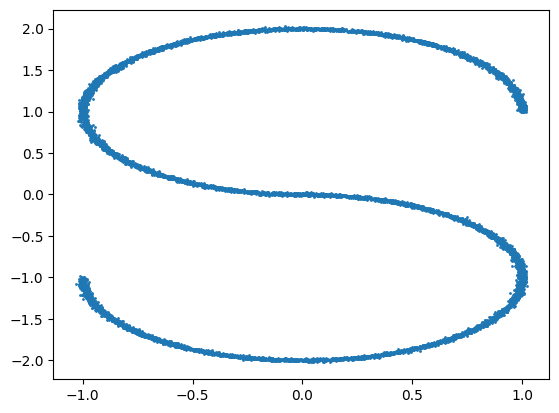

In [ ]:
s_x, s_y = datasets.make_s_curve(n_samples=10000, noise=0.01)
s_x = s_x[:, [0, 2]]
plt.scatter(s_x[:, 0], s_x[:, 1], s=1);

In [ ]:
s_x[0]

array([ 0.53895821, -1.85283498])

Реальные объекты $x_i$ - точки с кривой s (из ее распределения).

In [ ]:
# всегда точка с s (по приколу)
gen_dummy = lambda x: (0, 0)
gen_dummy(1010) # это не то что мы хотели конечно, но подходит. Проблема.

(0, 0)

In [ ]:
class Dataset2d:
    def __init__(self, x, y):
        self.x = x
        self.y = y # т.к. s_curve возвращает x и y, хотя нам нужны только x

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.shape[0]


class Generator2d(nn.Module):
    def __init__(self, lat_size):
        super().__init__()
        self.lat_size = lat_size # размер шумового вектора

        self.net = nn.Sequential( # G - набор полносвязных слоев, как и D
            nn.Linear(lat_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 2), # генератор выдает точку с координатами (x, y)
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)


class Discriminator2d(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [ ]:
# создадим сети, оптимизаторы, прайор и даталоадер

tr_dataloader_2d = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(s_x, dtype=torch.float32), torch.tensor(s_y)),
    batch_size=64,
    shuffle=True,
    num_workers=64,
)

gen_2d = Generator2d(2)
gen_2d.to(device)

discr_2d = Discriminator2d()
discr_2d.to(device)

prior_2d = torch.distributions.Normal(
    torch.zeros(2).to(device), torch.ones(2).to(device)
) # создает шумовой вектор из N(0, 1)

gen_opt_2d = optim.Adam(gen_2d.parameters(), lr=3e-4)
discr_opt_2d = optim.Adam(discr_2d.parameters(), lr=3e-4, betas=(0.9, 0.999))

storage_2d = []

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


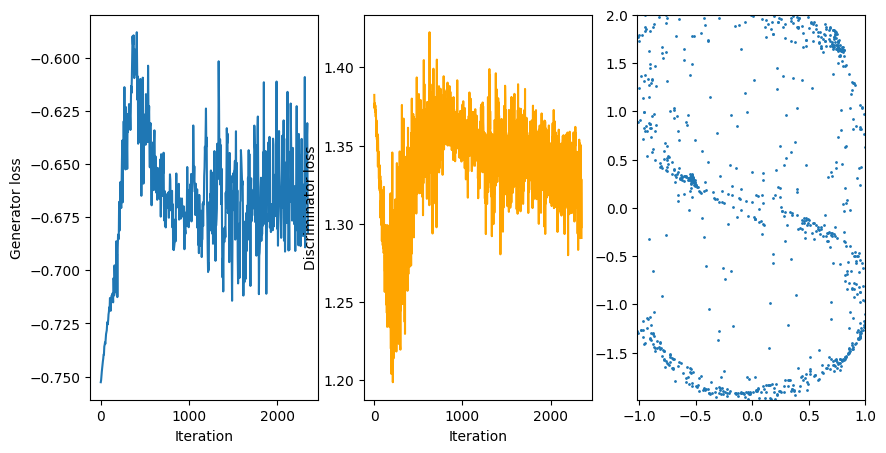

In [ ]:
train_gan(
    tr_dataloader_2d,
    gen_2d,
    discr_2d,
    gen_opt_2d,
    discr_opt_2d,
    gan_loss,
    prior_2d,
    num_epochs=15,
    gen_steps=1,
    discr_steps=3,
    verbose_num_iters=10,
    storage=storage_2d
)

Наблюдаемые пики у G и D из-за их состязания

Визуализируем распределение, которое выучил генератор.

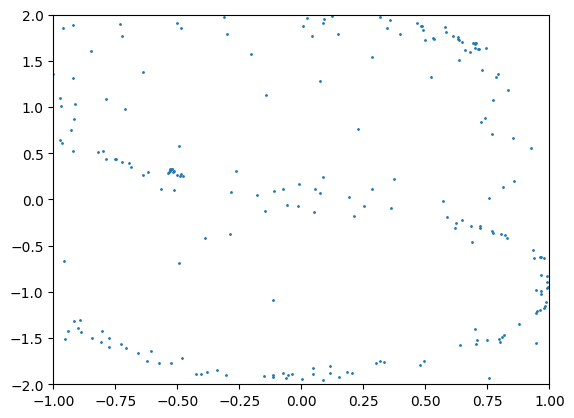

In [ ]:
z = prior_2d.sample((256,))

sampled_2d = gen_2d(z)

plt.xlim(-1, 1)
plt.ylim(-2, 2)

plt.scatter(
    sampled_2d[:, 0].cpu().detach().numpy(),
    sampled_2d[:, 1].cpu().detach().numpy(),
    s=1,
);

In [ ]:
z = prior_2d.sample((1,)) # 1 вектор на вход сетке, просто посмотреть, че на выходе генератора

sampled_2d = gen_2d(z)
sampled_2d

tensor([[-0.7052, -1.0225]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# Из графиков, полученных по время обучения, можно создать анимацию.

# import matplotlib.animation

# fig, ax = plt.subplots()

# def animate(i):
#   plt.cla()
#   plt.xlim(s_x[:, 0].min(), s_x[:, 0].max())
#   plt.ylim(s_x[:, 1].min(), s_x[:, 1].max())
#   plt.scatter(storage_2d[i][:, 0],
#               storage_2d[i][:, 1],
#               s=1
#               )


# animation_2d = matplotlib.animation.FuncAnimation(fig, animate, frames=len(storage_2d))
# animation_2d.save("animation_2d.gif", writer='imagemagick',fps=60)

2d данные отлично подходят и для демонстрации слабых мест GAN'ов: когда данные состоят из нескольких мод (кластеров), ганы подверждены двум сценариям.

1. Mode collapse: ситуация, когда GAN игнорирует часть кластеров и не пытается их выучить.
2. Смешение мод: когда GAN соединяется две моды перешейком. Этот случай, как правило, решается взятием более мощного дискриминатора и генератора. <- вместо двух окружностей будет одна

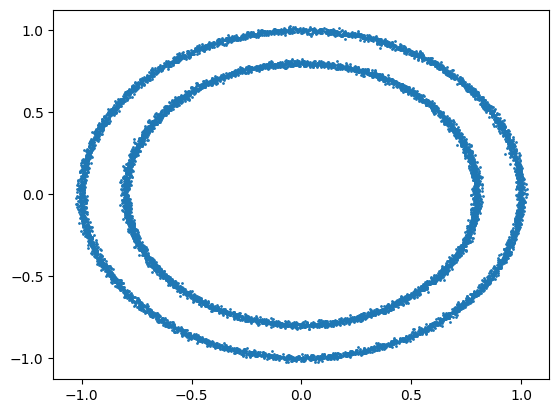

In [ ]:
circle_x, circle_y = datasets.make_circles(n_samples=10000, noise=0.01)
plt.scatter(circle_x[:, 0], circle_x[:, 1], s=1);

In [ ]:
tr_dataloader_circle = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(circle_x, dtype=torch.float32), torch.tensor(circle_y)),
    batch_size=64,
    shuffle=True,
    num_workers=64,
)

gen_circle = Generator2d(2)
gen_circle.to(device)

discr_circle = Discriminator2d()
discr_circle.to(device)

prior_circle = torch.distributions.Normal(
    torch.zeros(2).to(device), torch.ones(2).to(device)
)

gen_opt_circle = optim.Adam(gen_circle.parameters(), lr=3e-4)
discr_opt_circle = optim.Adam(discr_circle.parameters(), lr=3e-4, betas=(0.9, 0.999))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


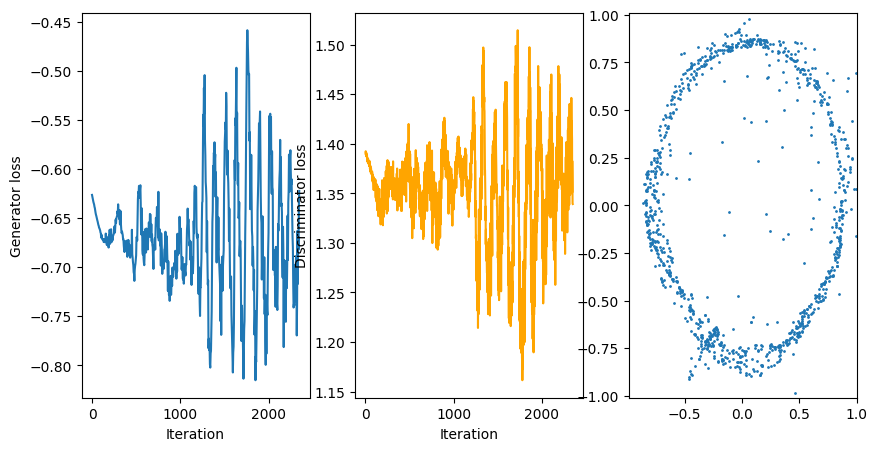

In [ ]:
train_gan(
    tr_dataloader_circle,
    gen_circle,
    discr_circle,
    gen_opt_circle,
    discr_opt_circle,
    gan_loss,
    prior_circle,
    num_epochs=15,
    gen_steps=1,
    discr_steps=3,
    verbose_num_iters=10,
)

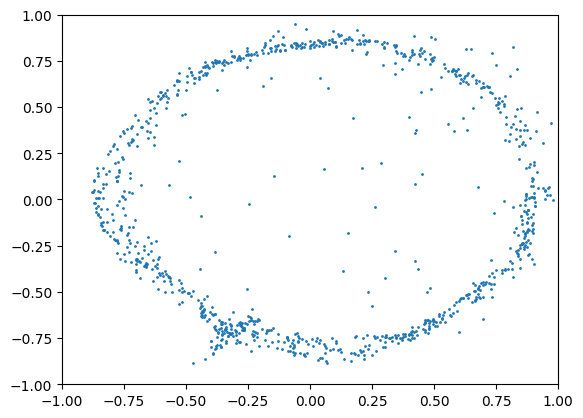

In [ ]:
z = prior_circle.sample((1024,))

sampled_circle = gen_circle(z)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.scatter(
    sampled_circle[:, 0].cpu().detach().numpy(),
    sampled_circle[:, 1].cpu().detach().numpy(),
    s=1,
)

## 2. Vanilla GAN: MNIST

Теперь давайте обучим ту же самую архитектуру на чуть-чуть более серьёзные данных. Попробуем генерировать цифры из датасета MNIST.

In [ ]:
class GeneratorMNIST(nn.Module):
    def __init__(self, lat_size, hidden=64):
        super().__init__()
        self.lat_size = lat_size

        self.net = nn.Sequential(
            nn.Linear(lat_size, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2 * hidden),
            nn.BatchNorm1d(2 * hidden),
            nn.ReLU(),
            nn.Linear(2 * hidden, 4 * hidden),
            nn.BatchNorm1d(4 * hidden),
            nn.ReLU(),
            nn.Linear(4 * hidden, 32 * 32),
            nn.Tanh(), # чтобы выход от -1 до 1 (как и у реальных изображений, они нормированы в этот интервал)
        )

    def forward(
        self, z: torch.Tensor, y: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        return self.net(z).view(-1, 1, 32, 32) # преобразование в квадрат для получения картинки


class DiscriminatorMNIST(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(32 * 32, 4 * hidden),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(4 * hidden, 2 * hidden),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(2 * hidden, hidden),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden, 1),
        )

    def forward(
        self, x: torch.Tensor, y: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        res = self.net(x.view(-1, 32 * 32)) # flatten перед поданием в сеть
        res = torch.sigmoid(res)
        return res

In [ ]:
transform = transforms.Compose(
    [transforms.Resize(32), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

trainset = MNIST(root="./data/", train=True, download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=64, pin_memory=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 140210746.70it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 56526222.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 55694267.79it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19579166.26it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
gen_mnist = GeneratorMNIST(100) # уже не двумерье
gen_mnist.to(device)

discr_mnist = DiscriminatorMNIST()
discr_mnist.to(device)

prior_mnist = torch.distributions.Normal(
    torch.zeros(100).to(device), torch.ones(100).to(device)
)

gen_opt_mnist = optim.Adam(gen_mnist.parameters(), lr=3e-4)
discr_opt_mnist = optim.Adam(discr_mnist.parameters(), lr=3e-4, betas=(0.5, 0.999))

Если у Вас вместо вывода сэмпла изображений пусто - попробуйте перезапустить обучение.
Mode collapse moments 🙈

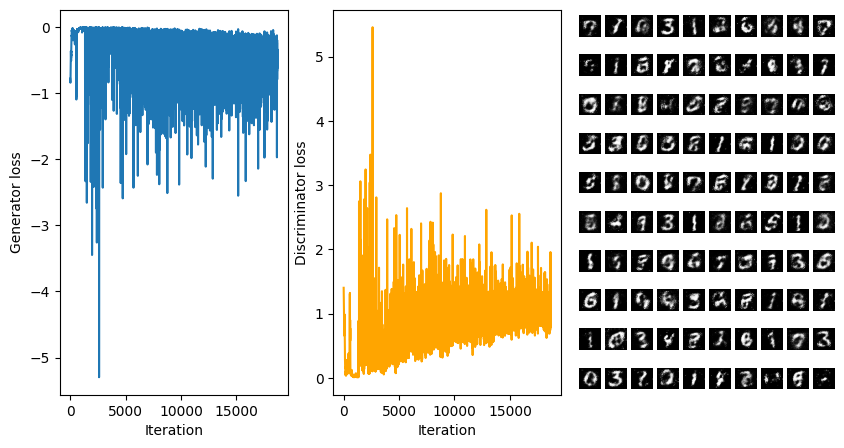

In [ ]:
train_gan(
    trainloader_mnist,
    gen_mnist,
    discr_mnist,
    gen_opt_mnist,
    discr_opt_mnist,
    gan_loss,
    prior_mnist,
    num_epochs=20,
    gen_steps=1,
    discr_steps=1,
    verbose_num_iters=100,
    data_type="mnist",
)

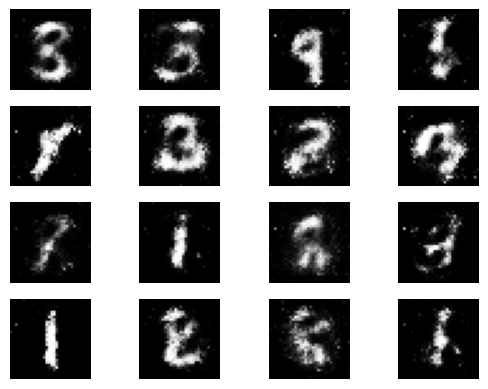

In [ ]:
z = prior_mnist.sample((16,))

sampled_mnist = gen_mnist(z)

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap="gray")

## 3. GAN: Fashion MNIST

### 3.1 Имплементируем работающее решение

In [ ]:
class SimpleDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.leaky_relu(self.fc1(x), 0.2) # leaky_relu: даем шанс для отрицательных
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = self.fc4(x)

        return x


class SimpleGenerator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.fc3 = nn.Linear(hidden_dim * 4, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.tanh(x)

        return x

In [ ]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 28 * 28
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 28 * 28
# Size of *first* hidden layer in the generator
g_hidden_size = 32

In [ ]:
# instantiate discriminator and generator
D = SimpleDiscriminator(input_size, d_hidden_size, d_output_size)
G = SimpleGenerator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

SimpleDiscriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

SimpleGenerator(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size) * 0.9 # не хотим, чтобы дискриминатор был очень хорошим
    else:
        labels = torch.ones(batch_size)
    criterion = nn.BCEWithLogitsLoss() # нет сигмоиды из-за BCE
    loss = criterion(D_out.squeeze(), labels)

    return loss


def fake_loss(D_out):
    # compare logits to fake labels
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # здесь 0 <=> 0.1
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss

In [ ]:
lr = 0.002

d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [ ]:
training_data = torchvision.datasets.FashionMNIST(
    root="data", train=True, download=True, transform=transforms.ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11700242.45it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200602.29it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3734064.56it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21463496.02it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



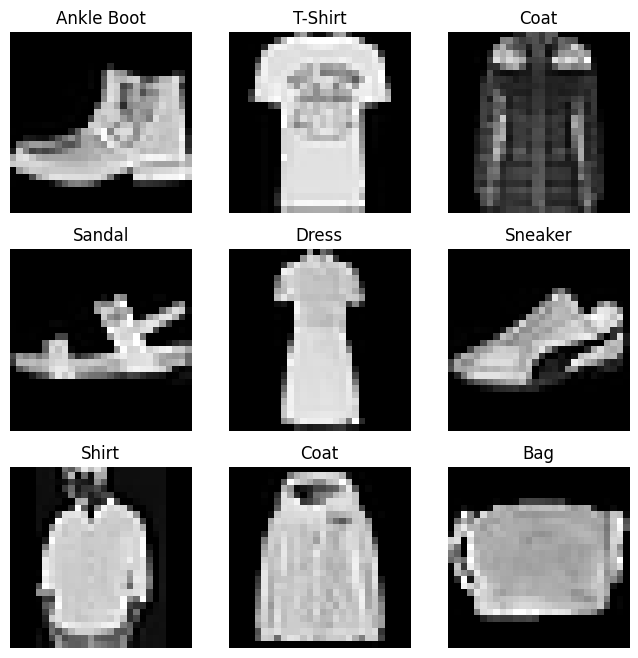

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, num_workers=64)

In [ ]:
D = SimpleDiscriminator(input_size, d_hidden_size, d_output_size)
G = SimpleGenerator(z_size, g_hidden_size, g_output_size)
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [ ]:
num_epochs = 40

samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size)) # фиксированный вектор, для отслеживания процесса (чтобы картинки были все качественнее и качественнее)
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    for batch_i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)

        ## Important rescaling step ##
        real_images = real_images * 2 - 1  # rescale input images from [0,1) to [-1, 1)

        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        # 1. Train with real images
        d_optimizer.zero_grad()

        # Compute the discriminator losses on real images
        # use smoothed labels
        op_real = D(real_images)
        d_real_loss = real_loss(op_real, smooth=True)

        # 2. Train with fake images

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        op_fake = D(fake_images)
        d_fake_loss = fake_loss(op_fake)

        # add up real and fake losses and perform backprop
        d_loss = d_fake_loss + d_real_loss
        d_loss.backward()
        d_optimizer.step()

        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================

        # 1. Train with fake images and flipped labels
        g_optimizer.zero_grad()

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        # using flipped labels!
        d_fake_loss = D(fake_images)
        g_loss = real_loss(d_fake_loss) # G старается сделать так, чтобы D говорил, что картинка настоящая на фейках

        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print(
                "Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}".format(
                    epoch + 1, num_epochs, d_loss.item(), g_loss.item()
                )
            )

    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval()  # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()  # back to train mode

Epoch [    1/   40] | d_loss: 1.3707 | g_loss: 0.7605
Epoch [    1/   40] | d_loss: 0.4287 | g_loss: 4.4872
Epoch [    1/   40] | d_loss: 0.8938 | g_loss: 3.6404
Epoch [    2/   40] | d_loss: 0.8074 | g_loss: 3.8918
Epoch [    2/   40] | d_loss: 1.1630 | g_loss: 2.4312
Epoch [    2/   40] | d_loss: 1.0227 | g_loss: 3.4866
Epoch [    3/   40] | d_loss: 0.9235 | g_loss: 2.4140
Epoch [    3/   40] | d_loss: 1.0959 | g_loss: 2.1607
Epoch [    3/   40] | d_loss: 0.9877 | g_loss: 1.9114
Epoch [    4/   40] | d_loss: 1.3041 | g_loss: 0.8217
Epoch [    4/   40] | d_loss: 1.1189 | g_loss: 2.2652
Epoch [    4/   40] | d_loss: 1.0566 | g_loss: 1.6508
Epoch [    5/   40] | d_loss: 1.2694 | g_loss: 1.1077
Epoch [    5/   40] | d_loss: 1.1294 | g_loss: 1.6609
Epoch [    5/   40] | d_loss: 1.2400 | g_loss: 1.2175
Epoch [    6/   40] | d_loss: 1.3273 | g_loss: 0.8142
Epoch [    6/   40] | d_loss: 1.3433 | g_loss: 1.0520
Epoch [    6/   40] | d_loss: 1.4264 | g_loss: 0.9052
Epoch [    7/   40] | d_loss

100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


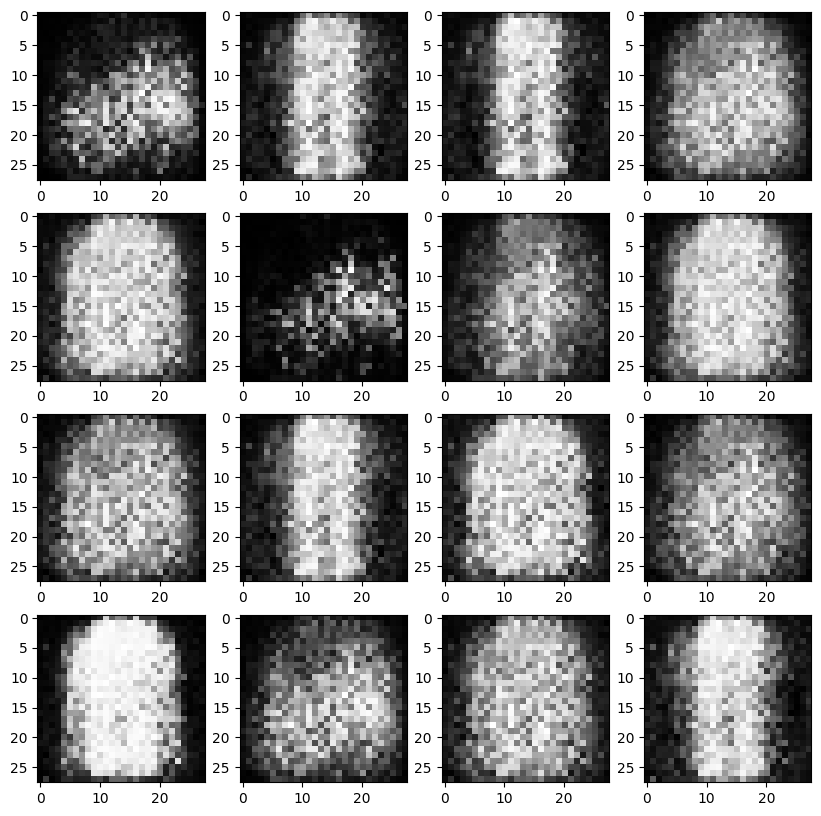

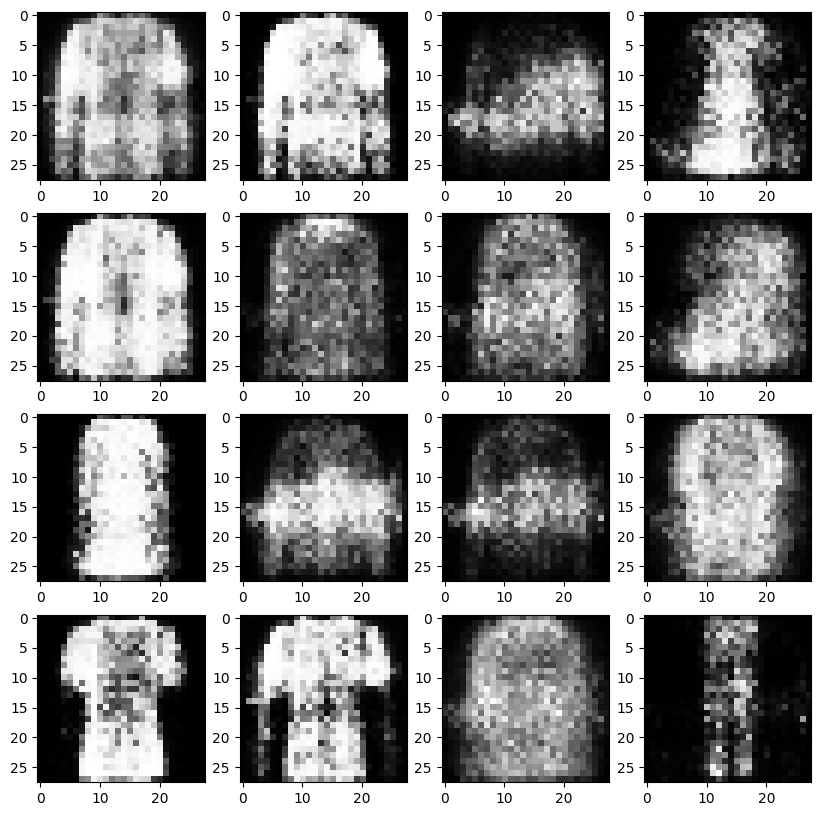

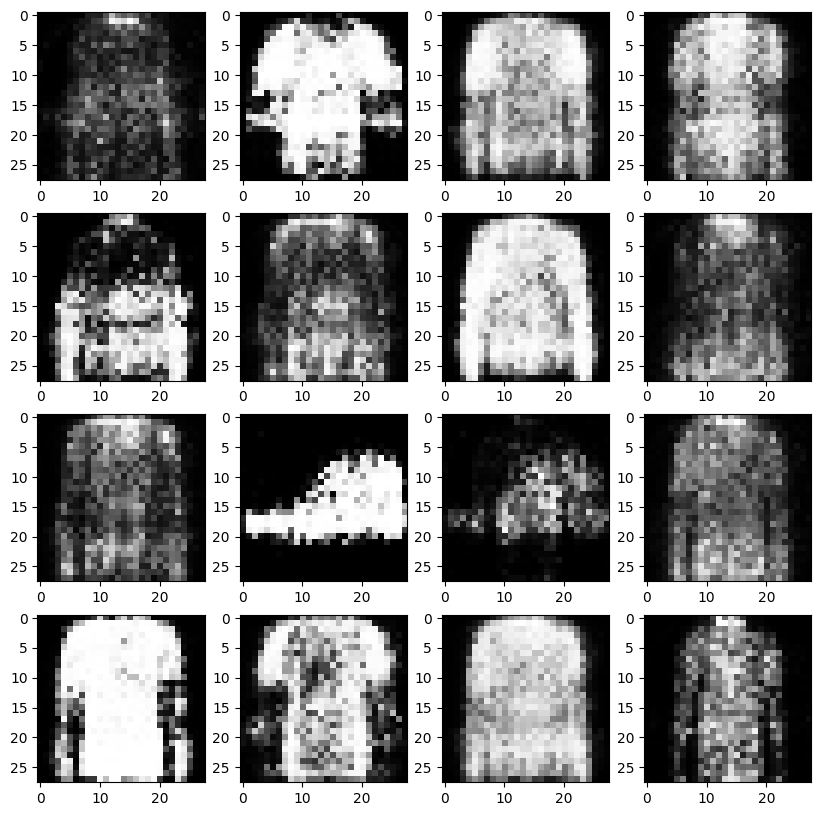

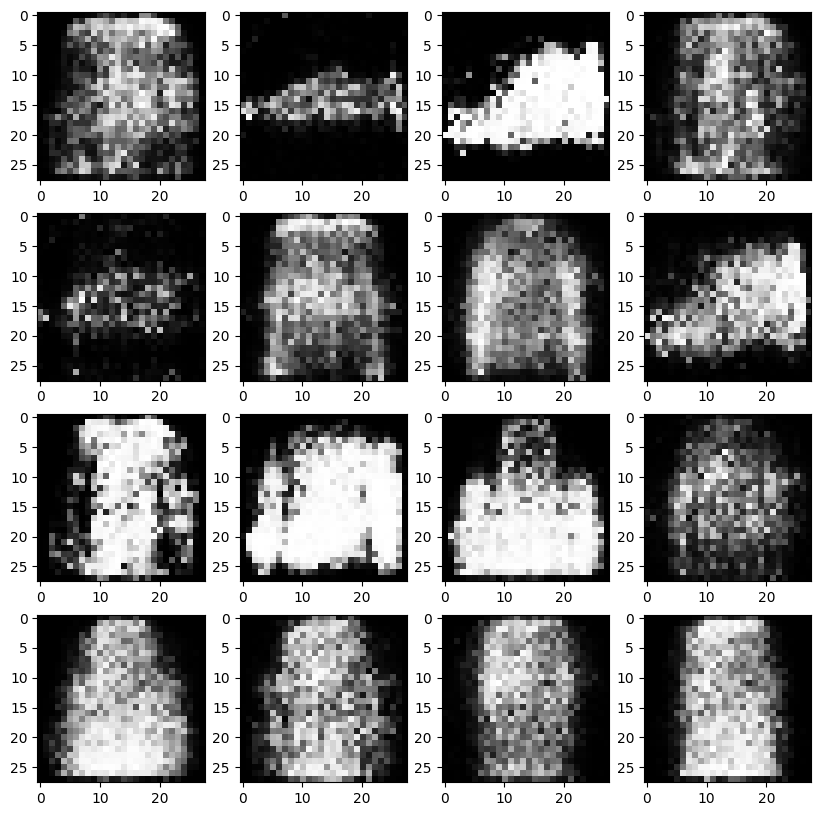

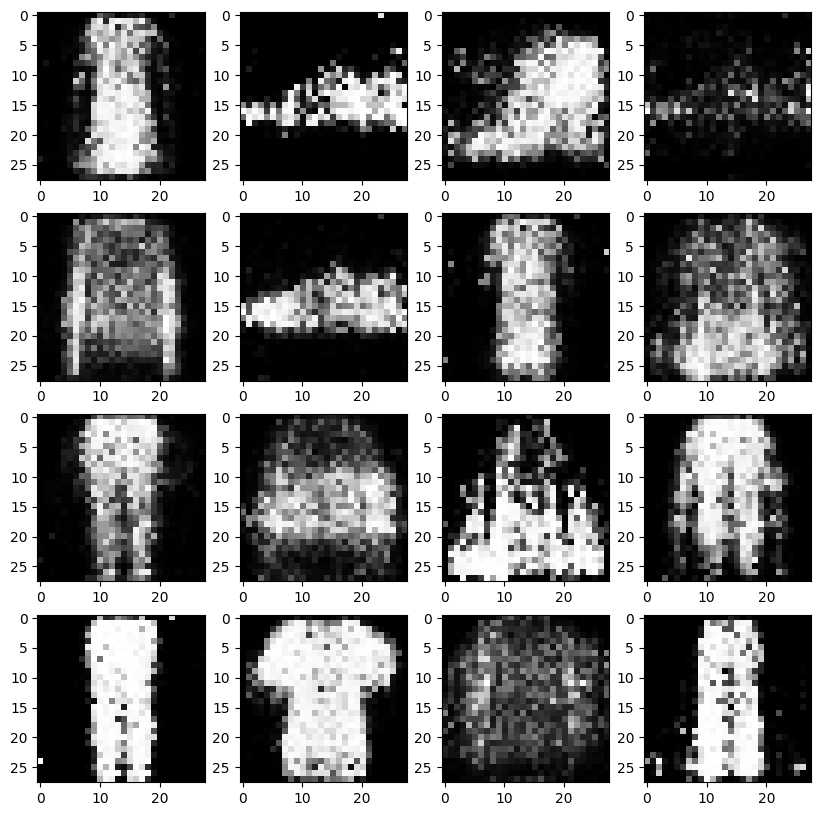

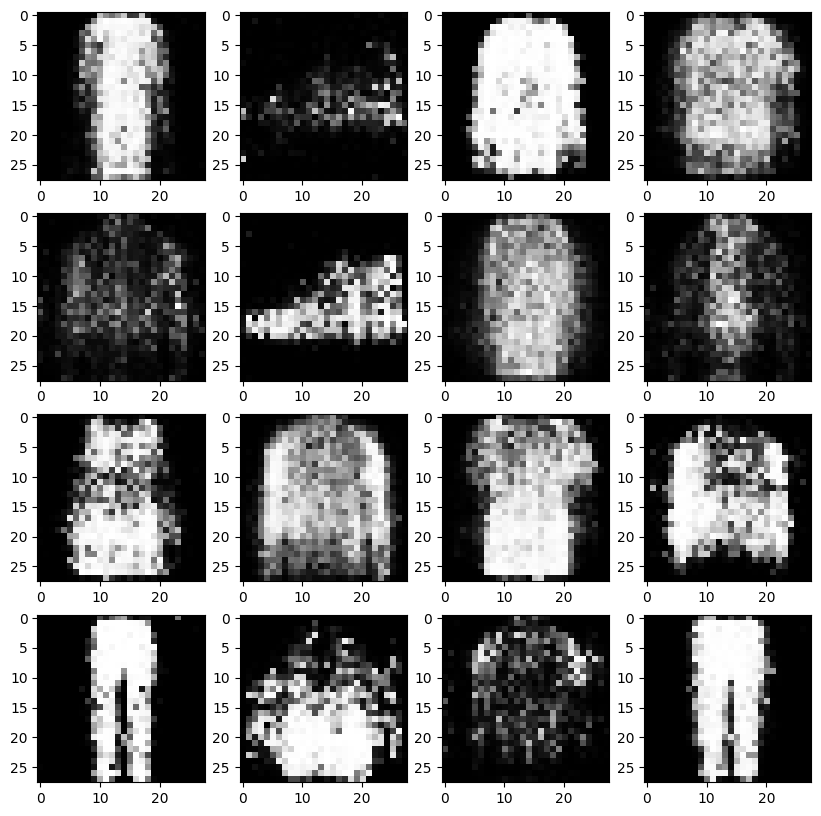

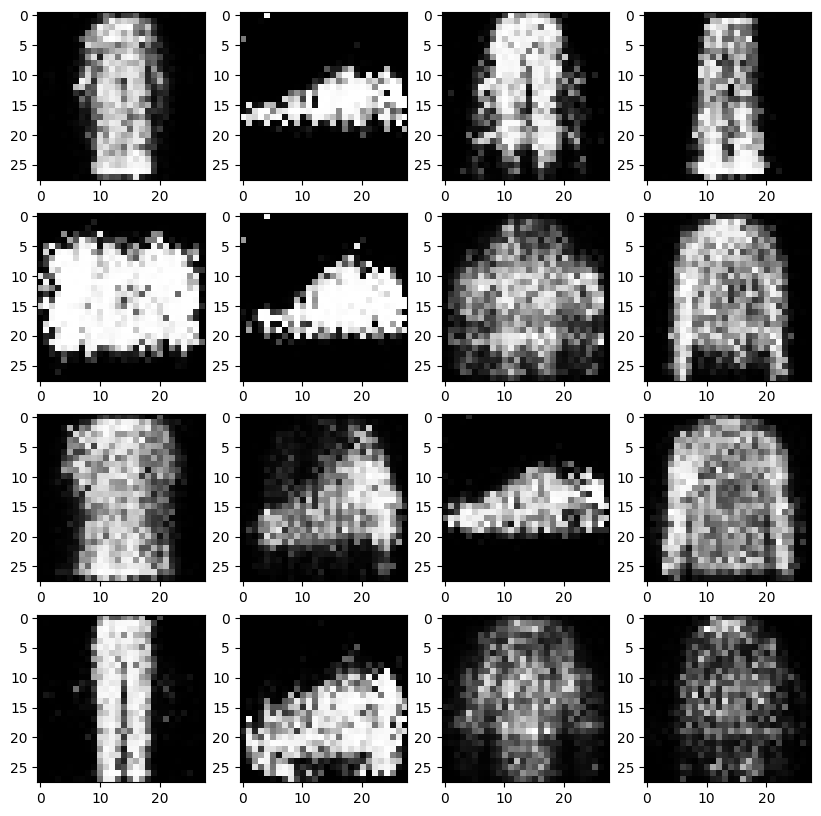

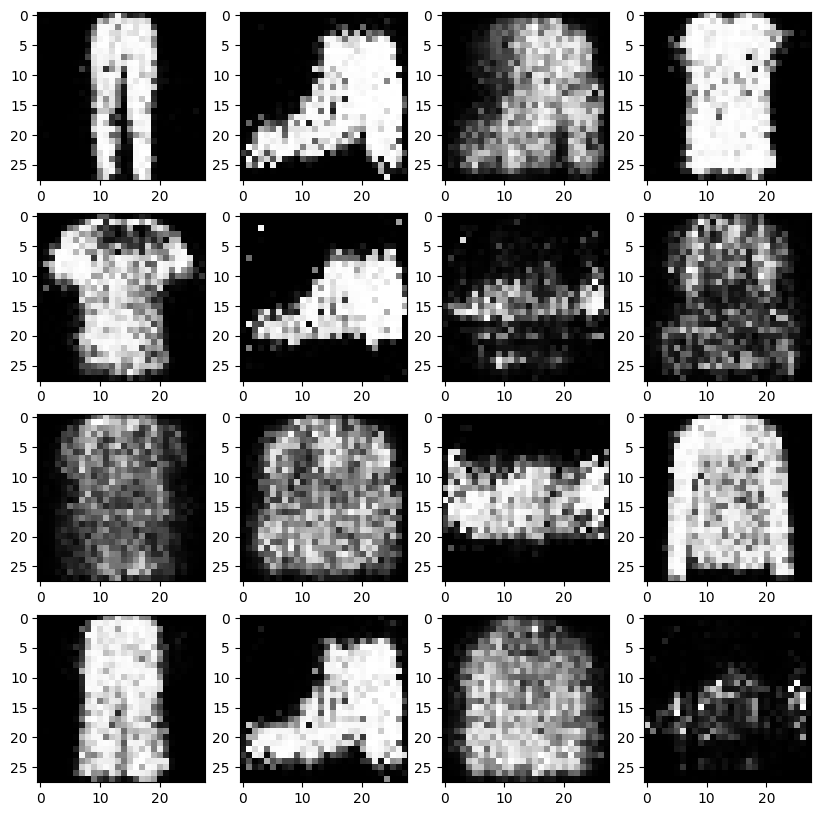

In [ ]:
figs = []

for l in range(0, len(samples), 5):
    step = 0
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(
                samples[l][step].reshape(28, 28).detach().numpy(), cmap="Greys_r"
            )
            step += 1
    figs.append(fig)

## 4. Оценка качества генерации

### Inception Score (IS)

В [оригинальной статье](https://arxiv.org/abs/1606.03498) предлагается оценивать качество генерации с использованием третьей модели - Inception.
​Ключевая идея заключается в попытке сформулировать в математических терминах то, что мы хотим получить от хорошей генерации: разнообразие сгенерированных объектов и четкость их прорисовки.

![image](https://miro.medium.com/max/2976/1*X29oOi1Tzch2j6MuG9XS1Q.png)
![image](https://miro.medium.com/max/2812/1*t8lE_W4UKQ8jKgzxCAbHTA.png)

В общих словах - мы сравниваем, как отличается распределение выхода классификатора в случаях, когда мы генерируем объекты одного класса, в сравнении с генерацией объектов разных классов.

![image](https://miro.medium.com/max/3472/1*hPEJY3MkOZyKFA6yEqzuyg.png)

Мы ожидаем, что если мы сгененировали объекты одного класса и они хорошо различимы, то просуммировав вероятности выхода классификатора мы получим распределение с пиком в том самом классе. В случае генерации объектов разных классов ожидается, что сумма выходов будет представлять равномерное распределение.
Чем больше непохожи такие распределение - тем лучше качество. Мы можем выразить степень различия распределений в терминах [KL-дивергенции](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).




### Frechet Inception Distance (FID)

Идея заключается в том, что мы ожидаем, что если два распределения совпадают, то и равны их моменты.

В [данном подходе](https://arxiv.org/abs/1512.00567) мы, аналогично IS, берем некоторую модель (в оригинале это Inception), прогоняем через нее выборки, а затем сравниваем, насколько похожи векторные представления объектов в данных выборках. Сделать мы это можем, апроксимирую распределения с помощью гауссиан $\mathcal{N}(\mu_1, \Sigma_1)$ и $\mathcal{N}(\mu_2, \Sigma_2)$, а затем сравнив их по формуле Frecher Distance = $\|\mu_1 – \mu_2\|^2 + Tr(\Sigma_1 + \Sigma_2 - 2 * \text{sqrt}(\Sigma_1*\Sigma_2))$.






![](https://miro.medium.com/max/875/0*GHvXKp6DQPAHGdqH)

### LPIPS

[Авторы](https://richzhang.github.io/PerceptualSimilarity/) отметили, что активации НС удивительной хорошо работают в качестве метрики схожести восприятия, продемонстрировав это на разных архитектурах. Идея схожа с предыдущими, но дополнительно используются новые слои, которые помогают еще лучше отколибровать оценку схожести изображений.

![](https://richzhang.github.io/PerceptualSimilarity/index_files/fig1_v2.jpg)

$$d_{LPIPS}(x,y)=\Sigma_l\frac{1}{H_lW_l}\Sigma_{i,j}||w_l\cdot(\hat{x}^l_{ij}-\hat{y}^l_{ij})||^2_2$$
$\hat{x}^l_{ij}$ и $\hat{y}^l_{ij}$ соотвествуют нормализованным представлением со слоя $l$ пикселя $(i, j)$, которые домножаются на дообученные веса.

In [ ]:
!pip install lpips -q

Возьмем произвольную картинку из выборки и посмотрим, как выглядят распределения LPIPS до данного объекта для классов внутри датасета.

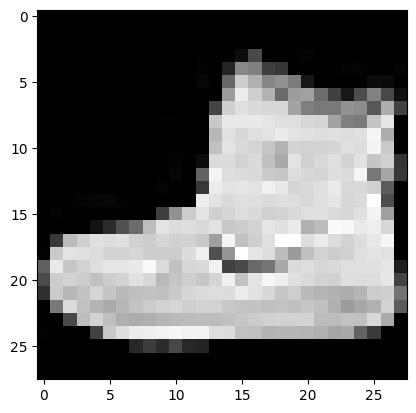

In [ ]:
original_img_idx = 0
original_img, original_label = training_data[original_img_idx]
plt.imshow(original_img.squeeze(), cmap='gray')

In [ ]:
from lpips import LPIPS
from tqdm.notebook import tqdm

# Выберем сеть, которую будем использовать для расчета LPIPS
criterion = LPIPS(net='alex', version='0.1').to(device)

def img2tensor(img):
  return torch.from_numpy(np.resize(img.cpu().detach().numpy(),(512,512)))

# Случайно выберем объекты из выборки для сравния
np.random.seed(10)
img_indices = np.random.choice(np.arange(len(training_data)), 1000)
img_indices = [idx for idx in img_indices if idx != original_img_idx]

distances, labels = [], []

for idx in tqdm(img_indices):
    img, label = training_data[idx]
    labels.append(label)
    distances.append(criterion(img2tensor(original_img).to(device), img2tensor(img).to(device)).detach().cpu().squeeze().item())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

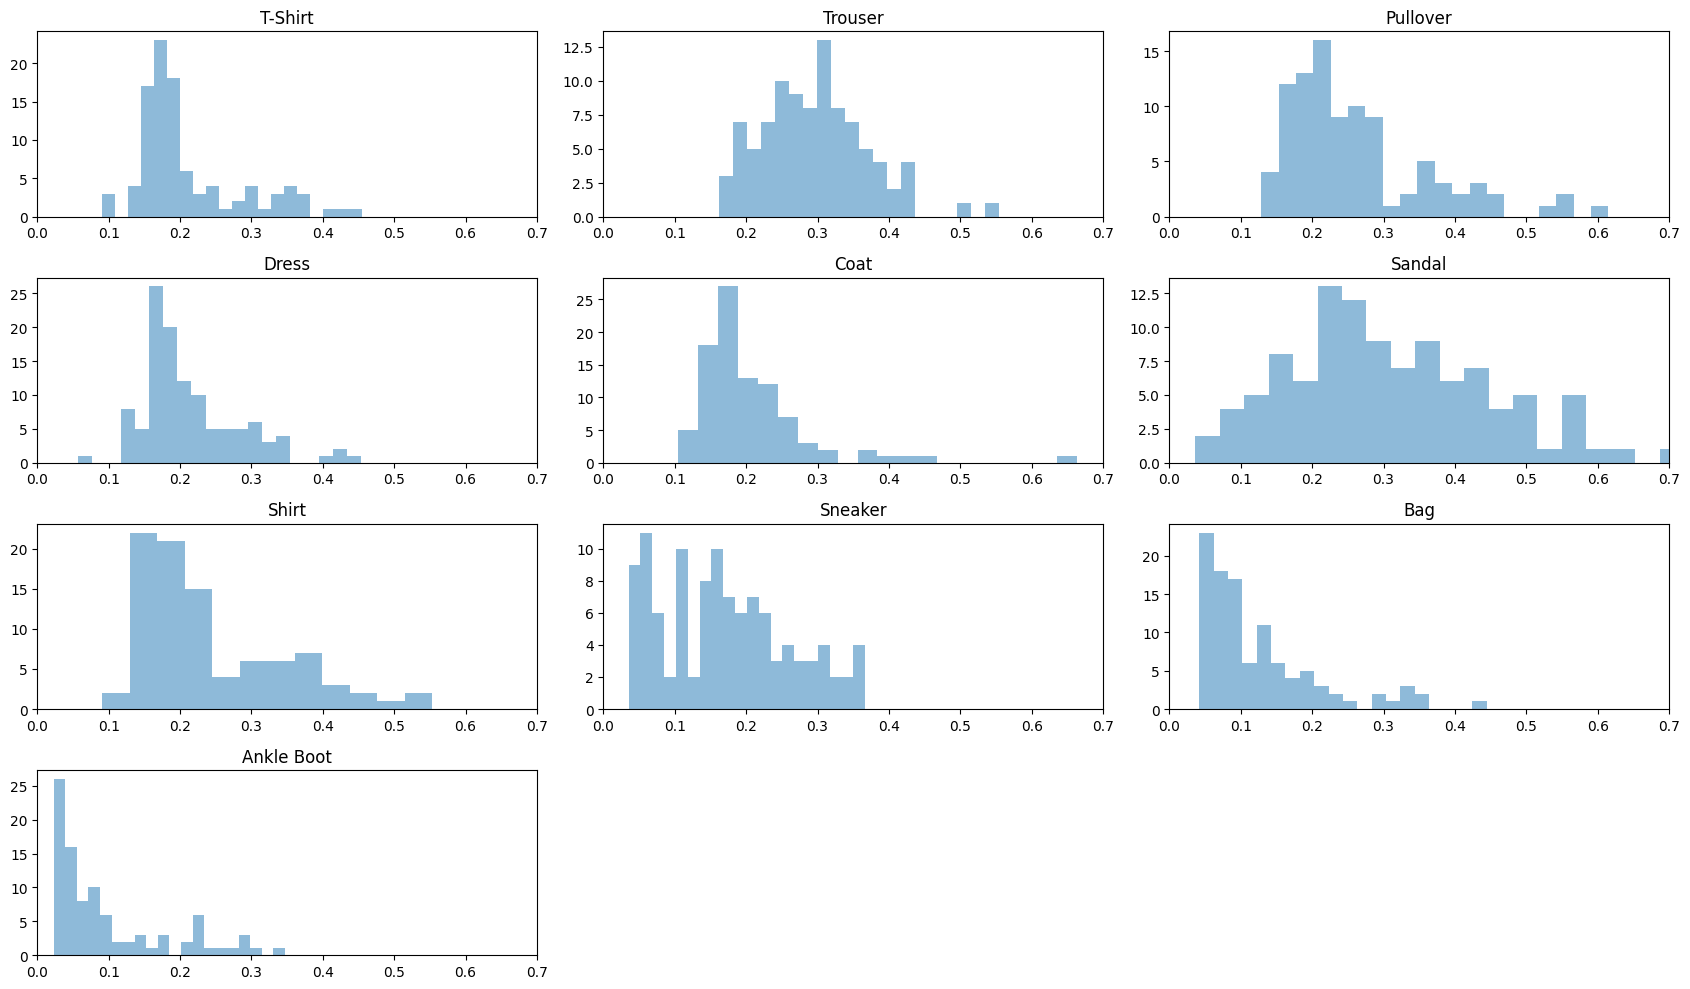

In [ ]:
plt.figure(figsize=(17,10))
n_classes = 10
for label in range(n_classes):
    plt.subplot(4,3,label+1)
    plt.title(labels_map[label])
    plt.xlim((0.,0.7))
    plt.hist(np.array(distances)[np.array(labels)==label], bins=20, alpha=0.5);
plt.tight_layout();

Найдем самые похожие на наш референс изображения в терминах LPIPS.

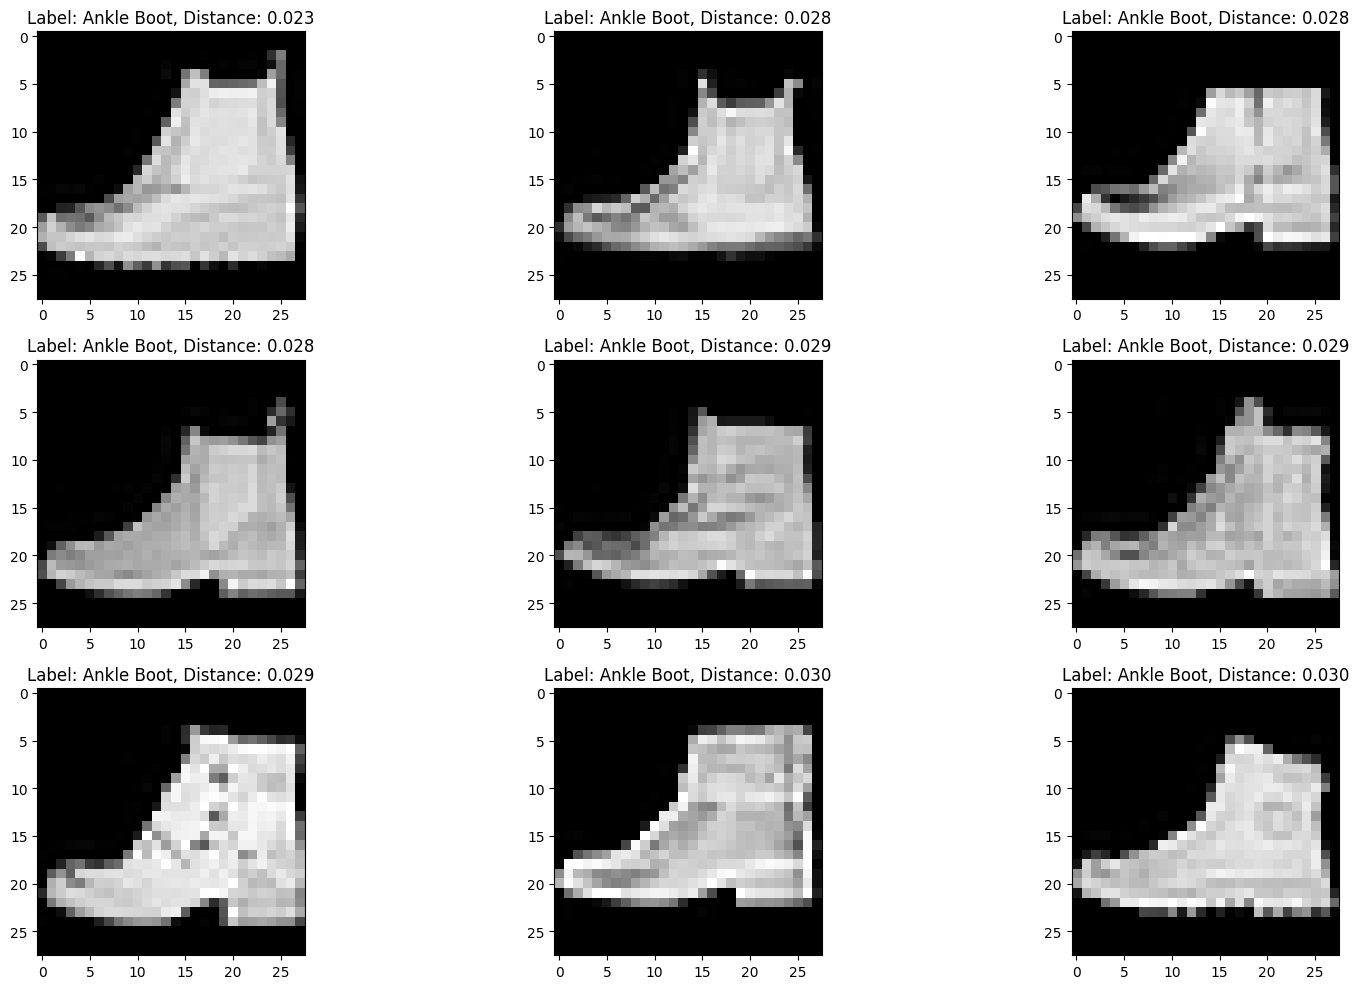

In [ ]:
plt.figure(figsize=(17,10))
closest_img_cnt = 9
closest_img_indices, closest_distances, closest_labels = [
    np.array(img_indices)[np.argsort(distances)[:closest_img_cnt]],
    np.array(distances)[np.argsort(distances)[:closest_img_cnt]],
    np.array(labels)[np.argsort(distances)[:closest_img_cnt]]]

for ax_idx, (img_idx, distance, label) in enumerate(zip(closest_img_indices, closest_distances, closest_labels)):
    img = np.array(training_data[img_idx][0])
    plt.subplot(3,3,ax_idx+1)
    plt.title(f'Label: %s, Distance: %.3f'%(labels_map[label], distance))
    plt.imshow(img.squeeze(), cmap='gray')
plt.tight_layout();